* 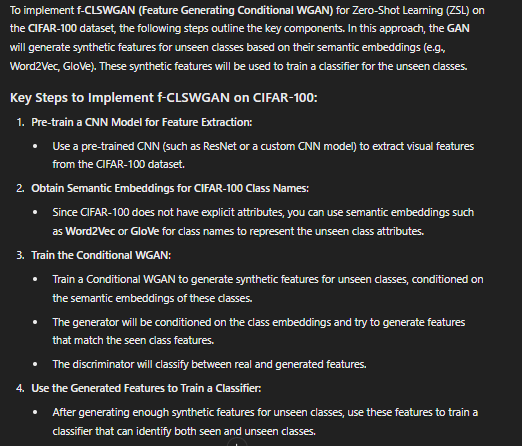

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec/glove.42B.300d.txt


In [2]:
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50

In [3]:
#Load data 
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar100.load_data()

#Normalize the image 
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

#pre-trained feature extractor 
resnet=ResNet50(weights='imagenet',include_top=False,
               input_shape=(32,32,3))

train_features=resnet.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1) 

test_features=resnet.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1726079495.324754      70 service.cc:145] XLA service 0x7b565c002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726079495.324801      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726079495.324805      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  29/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

I0000 00:00:1726079498.891966      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Get Semantic Embeddings: Use pre-trained word embeddings (e.g., Word2Vec or GloVe) to get semantic embeddings for the class names.

In [4]:
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

#convert glove to word2vec format
glove_input_file = '/kaggle/input/word2vec/glove.42B.300d.txt'
word2vec_output_file = '/kaggle/working/glove.42B.300d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

w2v_model=KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

#cifar100 class_names

cifar100_class_name=['apple', 'aquarium_fish','baby' , 'bear', 'beaver',
    'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
    'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can',
    'castle', 'caterpillar', 'cattle', 'chair',
    'chimpanzee', 'clock', 'cloud', 'cockroach',
    'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
    'girl', 'hamster', 'house', 'kangaroo',
    'computer_keyboard', 'lamp', 'lawn_mower',
    'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy',
    'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road',
    'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train',
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale',
    'willow_tree', 'wolf', 'woman', 'worm']

class_embeddings = [w2v_model[class_name] for class_name in cifar100_class_name if class_name in w2v_model]


/tmp/ipykernel_24/2769925256.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Define Conditional WGAN

In [5]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, LeakyReLU,Reshape, BatchNormalization,Input

def build_generator(input_dim,output_dim):
    model=tf.keras.Sequential([
        Dense(256,input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(1024),
        LeakyReLU(alpha=0.2),
        Dense(output_dim,activation='tanh')
        
    ])
    
    return model 

#Discriminator model 
def build_discriminator(input_dim):
    model=tf.keras.Sequential([
        Dense(512,input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1,activation='sigmoid')
    ])
    
    return model 
    
    

# Dimensions
noise_dim=100 #Dimension of noise vector 
embedding_dim =300 #Assuming 300D word embeddings 
feature_dim=train_features.shape[1]

#Build models 
generator=build_generator(noise_dim+embedding_dim, feature_dim)
discriminator=build_discriminator(feature_dim)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Train the WGAN: Implement the training loop for the Conditional WGAN,training the generator and discriminator alternately .

In [6]:
import tensorflow 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Optimizer
optimizer = Adam(0.0002, beta_1=0.5)

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Now, define the combined model

# Input layers
z_input = Input(shape=(noise_dim,))
class_embedding_input = Input(shape=(embedding_dim,))

# Concatenate noise and class embeddings
z_conditional_input = tf.keras.layers.Concatenate()([z_input, class_embedding_input])

# Generator output
generated_feature = generator(z_conditional_input)

# Discriminator's classification of generated features
validity = discriminator(generated_feature)

# Combined model (for training generator)
combined_model = Model([z_input, class_embedding_input], validity)

# Freeze the discriminator's weights when training the generator
discriminator.trainable = False

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer)

# Now you can train the generator using combined_model

# WGAN training function
def train_wgan(generator, discriminator, combined_model, epochs, batch_size, z_dim, class_embeddings, features_real):
    for epoch in range(epochs):
        # Sample noise and class embeddings for unseen classes
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        
        # Sample indices from the 1D array of class indices, then use them to get embeddings
        sampled_class_indices = np.random.choice(len(class_embeddings), size=batch_size)
        sampled_class_embeds = np.array([class_embeddings[i] for i in sampled_class_indices])

        # Concatenate noise with class embeddings
        noise_and_class_embed = np.concatenate([noise, sampled_class_embeds], axis=1)

        # Generate synthetic features
        generated_features = generator.predict(noise_and_class_embed)

        # Get real features for seen classes
        sampled_real_indices = np.random.choice(features_real.shape[0], size=batch_size)
        real_features = features_real[sampled_real_indices]

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_features, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_features, np.zeros((batch_size, 1)))

        # Train the generator (using discriminator's feedback via the combined model)
        g_loss = combined_model.train_on_batch([noise, sampled_class_embeds], np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Discriminator Loss: {d_loss_real + d_loss_fake}, Generator Loss: {g_loss}')

# Hyperparameters
epochs = 1000
batch_size = 64
z_dim = noise_dim

# Train the WGAN
train_wgan(generator, discriminator, combined_model, epochs, batch_size, z_dim, class_embeddings, train_features)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, Discriminator Loss: [array(4.0924473, dtype=float32), array(0., dtype=float32), array(2.376647, dtype=float32), array(0.34375, dtype=float32)], Generator Loss: [array(2.376647, dtype=float32), array(2.376647, dtype=float32), array(0.34375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━

Use Generated Features for Classifier Training: After training the WGAN, generate synthetic features for the unseen classes and train a classifier.